In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pywt
import matplotlib.pyplot as plt

from mne import read_epochs, set_log_level, compute_rank, concatenate_epochs

from mne.decoding import CSP, Scaler
from random import randint
from mrmr import mrmr_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import kurtosis, skew, moment, entropy, norm
from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold, cross_val_score, ShuffleSplit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [4]:
set_log_level('warning')
epochs = read_epochs('ica_epo.fif').pick('eeg').filter(0,240)
epochs.drop_channels(epochs.info['bads'])
epochs.apply_baseline((-1.4,-0.4))

Number of events,83
Events,left: 18r_pinch: 16r_stop: 17rest: 14right: 18
Time range,-2.000 – 7.999 sec
Baseline,-1.400 – -0.400 sec


In [5]:
selected_features = np.load('left_right_custom_features_1.npy')

[Text(0, -2e-06, ''),
 Text(0, 0.0, ''),
 Text(0, 2e-06, ''),
 Text(0, 4.000000000000001e-06, ''),
 Text(0, 6e-06, ''),
 Text(0, 8e-06, '')]

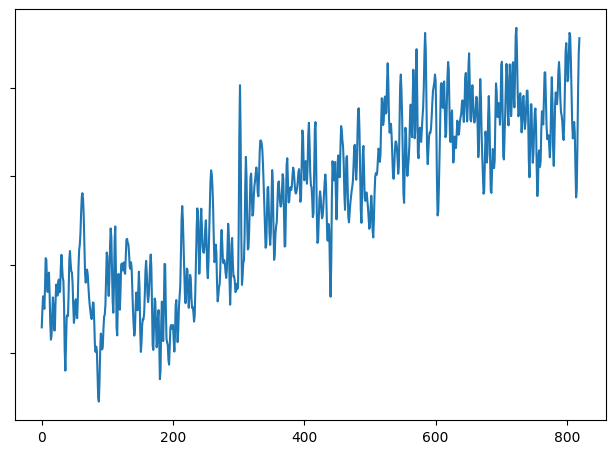

In [5]:
fig, axes = plt.subplots(1)
x = np.array(range(epochs['left'].copy().crop(0.4,1.2).get_data()[5,5].shape[0]))
axes.plot(x,epochs['left'].copy().crop(0.4,1.2).filter(0.,240).average().get_data()[5])
plt.tight_layout()
axes.set_yticklabels([])

In [6]:
unique, counts = np.unique(selected_features, return_counts=True)
print(unique[counts>2], counts[counts>2])

['A0_P8_skew' 'D4_F7_temp_centr' 'D6_TP7_krts' 'D6_TP7_min'] [5 3 9 3]


In [7]:
ch_idx = [epochs.info['ch_names'].index('P8'), epochs.info['ch_names'].index('TP7'), 
          epochs.info['ch_names'].index('F7')]

In [16]:
channels = {}
for idx, name in zip(ch_idx, ['F7', 'TP7', 'TP7']):
    channels[idx] = name

In [30]:
epochs['left'].pick(['F7', 'TP7', 'TP7']).copy().crop(0,2).average().plot

ValueError: Found 2 / 3 unique names, sel is not unique

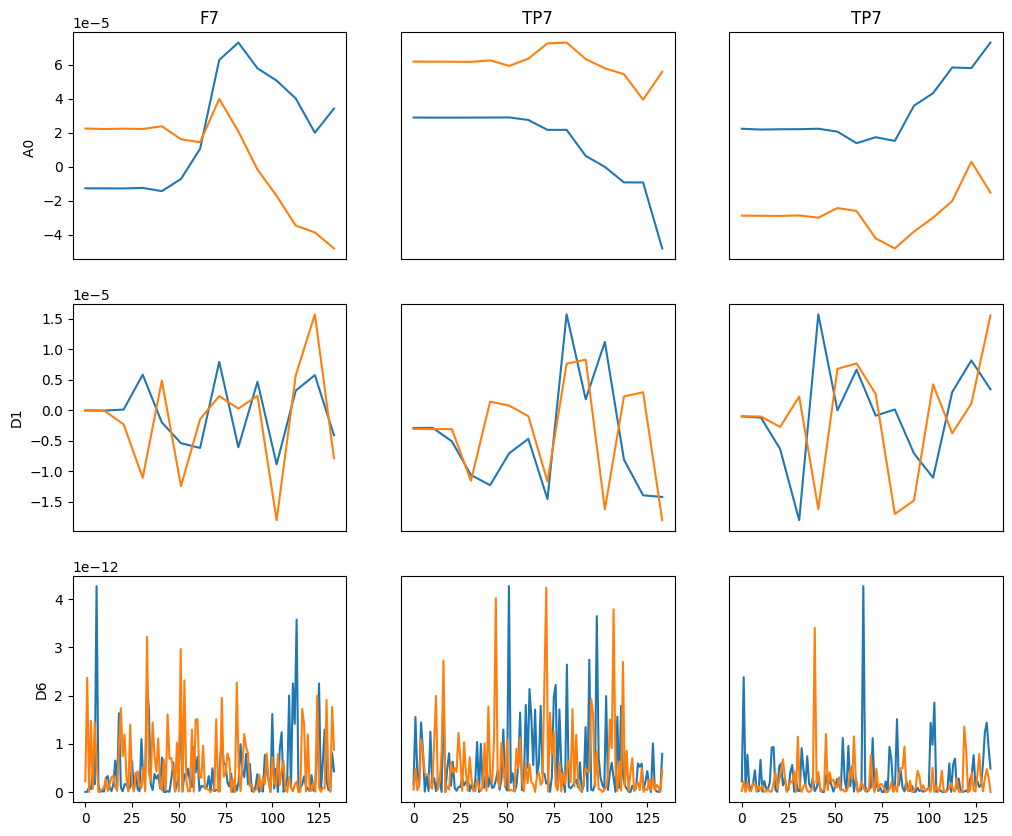

In [27]:
left_detail_coeffs = []
left_aprox_coeffs = []
right_detail_coeffs = []
right_aprox_coeffs = []

left_aprox_coeff = epochs['left'].copy().crop(0.2,1.2).average().get_data()
right_aprox_coeff = epochs['right'].copy().crop(0.2,1.2).average().get_data()

db = 'db4'
lvl, lvl1 = 4, 6

for dwt_lvl in range(7):
    left_det_coeff = np.apply_along_axis(dwt_det_coeff, 1, left_aprox_coeff, db=db)
    left_aprox_coeff = np.apply_along_axis(dwt_aprox_coeff, 1, left_aprox_coeff, db=db)
    right_det_coeff = np.apply_along_axis(dwt_det_coeff, 1, right_aprox_coeff, db=db)
    right_aprox_coeff = np.apply_along_axis(dwt_aprox_coeff, 1, right_aprox_coeff, db=db)
    
    left_detail_coeffs.append(left_det_coeff)
    left_aprox_coeffs.append(left_aprox_coeff)
    right_detail_coeffs.append(right_det_coeff.copy())
    right_aprox_coeffs.append(right_aprox_coeff.copy())
    
fig, axes = plt.subplots(3,3, figsize=(12,10))

j = 0
for ch in ch_idx:
    i = 0
    for lvl in range(3):
        left_x = []
        right_x = []
        lvl_name = ''
        if lvl == 0 :
            left_x = left_aprox_coeffs[-1][ch]
            right_x = right_aprox_coeffs[-1][ch]
            lvl_name = 'A0 '
        elif lvl == 1:
            left_x = left_detail_coeffs[lvl1][ch]
            right_x = right_detail_coeffs[lvl1][ch]
            lvl_name = 'D'+ str(lvl)
        else :
            left_x = left_detail_coeffs[lvl][ch]
            right_x = right_detail_coeffs[lvl][ch]
            lvl_name = 'D'+str(lvl1)
            
        if i != 2:
            axes[i,j].plot(np.arange(len(left_x)),left_xa)
            axes[i,j].plot(np.arange(len(right_x)),right_x)
        else :
            axes[i,j].plot(np.arange(len(left_x)),left_x**2)
            axes[i,j].plot(np.arange(len(right_x)),right_x**2)

        if j != 0 :
            axes[i,j].set_yticks([])
        elif j == 0 :
            axes[i,j].set_ylabel(lvl_name)
            
        if i != 2 :
            axes[i,j].set_xticks([])
        if i == 0:
            axes[i,j].set_title(channels[ch])
        
        i += 1
    j += 1
    
    axes[]
    

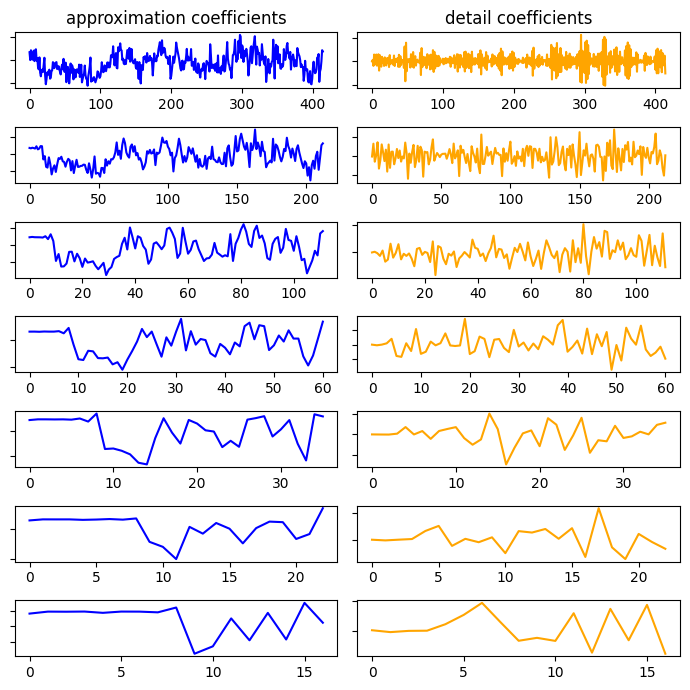

In [6]:
x = epochs['rest'].copy().crop(0.4,1.2).filter(0.,240).average().get_data()[5]

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(7,7))
for lvl in range(7):
    break;
    (x, coeff_d) = pywt.dwt(x, 'db6')
    axes[lvl, 0].plot(x, color='blue')    
    axes[lvl, 1].plot(coeff_d, color='orange')
    if lvl == 0:
        axes[lvl,0].set_title('approximation coefficients', )
        axes[lvl,1].set_title('detail coefficients', )
    axes[lvl,0].set_yticklabels([])
    axes[lvl,1].set_yticklabels([])
plt.tight_layout()
plt.show()

In [9]:
def dwt_det_coeff(x, db='db2'):
    aprx, det = pywt.dwt(x,db)
    return det

def dwt_aprox_coeff(x, db='db2'):
    aprx, det = pywt.dwt(x,db)
    return aprx

def rms(x):
    return np.sqrt(np.mean(x**2))

def slope(x):
    t = np.linspace(0, len(x)-1, len(x))
    return np.polyfit(t, x, 1)[0]

def autocorr(x):
    return float(np.correlate(x,x))
    
def temp_centroid(x):
    nom = [x[i] * i for i in range(x.shape[0])]
    return sum(nom)/sum(x)

def energy(x):
    return sum(x**2)

def med_abs_diff(x):
    return np.median(np.abs(np.diff(x)))

def mean_abs_diff(x):
    return np.mean(np.abs(np.diff(x)))

def calc_centroid(x, fs=1024):
    energy = np.array(x) ** 2
    t = range(len(x))
    t = [float(x) / fs for x in t]
    t_energy = np.dot(np.array(t), np.array(energy))
    energy_sum = np.sum(energy)

    if energy_sum == 0 or t_energy == 0:
        centroid = 0
    else:
        centroid = t_energy / energy_sum

    return centroid

In [6]:
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
le = LabelEncoder()
scaler = Scaler(info=epochs.info)

In [57]:
pca = PCA(n_components=0.9)

Left Vs Rest

In [24]:
conditions = ['left','rest']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
train_data = subset.copy().crop(0.4,1.2).get_data()    
time_config = (3,0.4,300,100)

<Info | 11 non-empty values
 bads: []
 ch_names: AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC1, C3, C5, T7, TP7, CP5, ...
 chs: 55 EEG
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 240.0 Hz
 meas_date: 2022-12-02 14:16:33 UTC
 meas_id: 4 items (dict)
 nchan: 55
 projs: []
 sfreq: 1024.0 Hz
>

In [37]:
find_best_dwt_score()

wv  db1  at lvl 0  :  0.4963636363636363
.
['C6_max', 'P10_min', 'F4_max', 'P10_min', 'P9_max', 'P10_min', 'P9_max']
.
wv  db1  at lvl 3  :  0.7263636363636363
.
['PO7_max', 'Fp2_min', 'Fp2_min', 'F4_min', 'F4_min', 'CP1_max', 'FC5_max', 'P9_min', 'Fp2_max', 'F5_min', 'CP3_min', 'AF3_min', 'P9_min', 'F7_max', 'AF4_max']
.
wv  db5  at lvl 4  :  0.7300000000000001
.
['PO7_min', 'Fp2_max', 'Fp2_min', 'F3_max', 'P10_min', 'O2_max', 'Fp2_min', 'Fp2_min', 'P10_min', 'FT7_max', 'AF7_min', 'P9_max', 'C4_min']
.
wv  db6  at lvl 4  :  0.7472727272727273
.
['Fp2_min', 'Fp2_min', 'Fp2_max', 'P10_min', 'P10_min', 'F3_min', 'FC1_min', 'Fp2_max', 'AF4_max', 'CPz_min', 'P9_min', 'PO4_min', 'FC1_max']
.
wv  db9  at lvl 4  :  0.7581818181818182
.
['Fp2_max', 'Fp2_max', 'F3_min', 'PO8_max', 'P10_max', 'P9_min', 'P10_max', 'Fp2_max', 'PO8_max', 'Fp2_min', 'AF4_min', 'AF4_min', 'F4_min', 'CP1_min']
.
wv  db14  at lvl 4  :  0.760909090909091
.
['C2_min', 'O1_max', 'CP3_max', 'Fp2_min', 'P10_min', 'P9_min', 

In [33]:
#bior
find_best_dwt_score(bior=True)

wv  bior2.2  at lvl 0  :  0.4636363636363637
.
['F7_min', 'P10_max', 'P10_max', 'T7_min', 'T7_min', 'FT7_max']
.
wv  bior2.2  at lvl 1  :  0.5745454545454545
.
['C6_min', 'P9_min', 'F3_max', 'P9_min', 'T7_min', 'TP8_min', 'P10_min']
.
wv  bior2.2  at lvl 4  :  0.6063636363636364
.
['PO7_max', 'PO7_min', 'Fp2_min', 'Fp2_max', 'P10_max', 'Fp2_max', 'TP8_max', 'AF3_min', 'FC1_max', 'CP2_max', 'FT7_max', 'P9_min', 'TP8_min', 'AF4_max']
.
wv  bior2.2  at lvl 5  :  0.7290909090909091
.
['O1_min', 'PO7_max', 'P10_min', 'P1_max', 'Fp2_min', 'Fp2_max', 'AF4_max', 'P10_max', 'P9_min', 'P9_min', 'T7_max', 'O2_min']
.


test with approx coeff

In [34]:
find_best_dwt_score(det=False)

wv  db1  at lvl 0  :  0.4954545454545455
.
['PO3_max', 'PO3_min', 'CP6_max', 'Iz_min', 'P9_min', 'PO4_min', 'P10_max', 'CP1_mean', 'Iz_min', 'Fp2_min', 'Iz_min', 'O2_min', 'FC5_max']
.
wv  db1  at lvl 1  :  0.5045454545454545
.
['PO3_max', 'PO3_min', 'CP6_mean', 'Iz_min', 'P9_min', 'PO4_min', 'P10_max', 'Iz_min', 'T7_max', 'Iz_min', 'P10_min', 'P3_min', 'FC5_max']
.
wv  db2  at lvl 1  :  0.51
.
['PO3_max', 'PO3_min', 'CP6_max', 'Iz_min', 'P9_min', 'PO4_min', 'P10_max', 'Iz_min', 'CP1_mean', 'Iz_min', 'P10_min', 'P3_min', 'FC5_max']
.
wv  db3  at lvl 1  :  0.5190909090909092
.
['PO3_max', 'PO3_min', 'CP6_mean', 'Iz_min', 'P9_min', 'PO4_min', 'P10_max', 'P8_min', 'Iz_min', 'POz_min', 'P10_min', 'P3_min', 'FC5_max']
.


Left Vs Right

In [16]:
conditions = ['left','right']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
train_data = subset.copy().crop(0.2,1).get_data()    
time_config = (3,0.4,300,100)

In [17]:
find_best_dwt_score()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.32it/s]


0.75  with  db2  :  1  and 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.01it/s]


0.8666666666666666  with  db2  :  2  and 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.99it/s]


0.8666666666666668  with  db2  :  3  and 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.34it/s]


db db2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.21it/s]


0.8666666666666668  with  db4  :  3  and 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.68it/s]


0.8666666666666668  with  db4  :  1  and 2
db db4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.16it/s]


0.9  with  db6  :  3  and 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.16it/s]


db db6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.31it/s]


0.9  with  db16  :  4  and 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.50it/s]


db db16


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.33it/s]


0.9  with  db24  :  1  and 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.37it/s]


db db24


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.38it/s]


0.9  with  db32  :  5  and 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.28it/s]


0.9166666666666666  with  db32  :  3  and 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.43it/s]


db db32


In [18]:
find_best_dwt_score()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.55it/s]


0.8  with  db2  :  1  and 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.70it/s]


0.85  with  db2  :  2  and 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.51it/s]


0.8666666666666666  with  db2  :  3  and 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.89it/s]


0.8666666666666666  with  db2  :  5  and 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.60it/s]


0.8833333333333334  with  db2  :  3  and 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.30it/s]


db db2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.19it/s]


0.9333333333333333  with  db4  :  4  and 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.55it/s]


db db4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.49it/s]


db db6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.52it/s]


db db16


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.95it/s]


db db24


test with approx coeff

In [41]:
find_best_dwt_score(det=False)

wv  db1  at lvl 0  :  0.375
.
['PO3_mean', 'P9_min', 'P9_min', 'CP6_min', 'P10_min', 'P9_min', 'CP1_min', 'Pz_min', 'AF3_min', 'FC1_max', 'P10_max', 'Fp2_max', 'Iz_min', 'F7_min']
.
wv  db1  at lvl 2  :  0.3833333333333333
.
['PO3_mean', 'P9_min', 'P9_min', 'CP6_min', 'P10_min', 'P9_min', 'CP1_min', 'Pz_min', 'CP1_min', 'FC2_min', 'O1_min', 'Fp2_max', 'P1_min']
.
wv  db1  at lvl 4  :  0.4083333333333333
.
['PO3_min', 'P9_min', 'P9_min', 'CP6_min', 'P10_min', 'Fp2_max', 'P9_min', 'Pz_min', 'POz_min', 'P10_min', 'O1_min', 'Fp2_max', 'Oz_min']
.
wv  db2  at lvl 4  :  0.425
.
['PO3_mean', 'P9_min', 'P9_min', 'CP6_min', 'P10_min', 'Fp2_max', 'P9_min', 'Pz_min', 'CP1_min', 'P10_min', 'O1_min', 'Fp2_max', 'P10_min']
.
wv  db7  at lvl 4  :  0.4333333333333334
.
['PO3_min', 'P9_min', 'P9_min', 'CP6_min', 'P10_min', 'Fp2_max', 'P9_min', 'Pz_min', 'P1_min', 'P10_mean', 'O1_min', 'TP8_min', 'P10_min', 'PO8_min']
.


In [42]:
#bior
find_best_dwt_score(bior=True)

wv  bior2.2  at lvl 0  :  0.5166666666666667
.
['P10_max', 'F5_max', 'TP8_min', 'T7_min', 'F7_min', 'P10_min']
.
wv  bior2.4  at lvl 2  :  0.5583333333333333
.
['P10_max', 'F5_min', 'P9_max', 'P10_min', 'T7_min', 'T7_min', 'Iz_max', 'F7_min', 'TP8_max', 'TP8_max', 'FC5_min']
.
wv  bior2.4  at lvl 7  :  0.575
.
['FC1_max', 'P7_max', 'Fp2_max', 'Iz_max', 'P9_max', 'Fp2_max', 'P9_max', 'O2_max', 'P10_min', 'Fz_min', 'Fp2_max', 'P9_max', 'P10_max', 'O2_min', 'FCz_min']
.
wv  bior2.8  at lvl 3  :  0.5833333333333333
.
['Fp2_min', 'FC5_max', 'P9_min', 'P9_min', 'AF4_min', 'Iz_min', 'P10_min', 'F2_max', 'AF8_max', 'AF3_min', 'AF4_min', 'Fz_max', 'FT7_max']
.
wv  bior3.3  at lvl 6  :  0.625
.
['O1_min', 'P4_max', 'PO7_min', 'O2_min', 'Fp2_min', 'CP3_min', 'T7_min', 'P10_min', 'T7_max', 'TP8_min', 'Cz_max', 'P9_min', 'P1_max', 'FC1_max']
.


CSP to one level

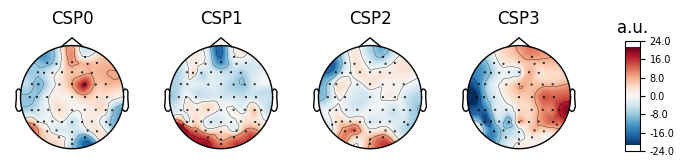

In [9]:
data = subset.copy().crop(.1,1.2).get_data()
data = np.apply_along_axis(dwt_coeff, 2, data, db='db2',lvl=1)
csp.fit(data, y)
csp.plot_patterns(subset.info)
print()

Stat features of DWT coefficients 

In [21]:
initial_features = []
st_features = ['mean','energy','std','max','min']
for ft in st_features:
    for ch in subset.info['chs']:
        initial_features.append(ch['ch_name'] + '_' + ft)

In [15]:
def find_best_dwt_score(det=True, bior=False):
    scores = []
    best_score = 0
    dbs = ['db2','db4','db6','db16','db24','db32']
    if bior:
        dbs = ['bior2.2',
             'bior2.8',
             'bior3.1',
             'bior5.5',]
    
    count = 0
    for db in dbs :
        lvl2 = 6
        if count < 4:
            detail_coeffs, aprox_coeffs = get_coeffs(db) 
            while lvl2 > 1:
                lvl_count = 0
                for lvl in range(1,lvl2):
                    score = test_lvl(detail_coeffs, aprox_coeffs, lvl, lvl2)
                    if lvl_count < 7 :
                        if score >= best_score:
                            best_score = score
                            count = 0
                            lvl_count = 0
                            print(best_score, ' with ', db, ' : ', lvl, ' and', lvl2)
                    lvl_count +=1
                lvl2 -= 1
            print('db', db)
        count +=1
           

In [9]:
def test_lvl(detail_coeffs, aprox_coeffs, lvl, lvl1, classifier='lda'):
    score = []
    selected_features = []
    for train_rep in range(3):  
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=randint(15,50)+train_rep)        
        cv_split = cv.split(detail_coeffs[lvl], y)
        
        mrmr_features = None  
        median_score = []
        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]  

            x_train, x_test = get_feature_vector(detail_coeffs, aprox_coeffs, lvl, lvl1, train_idx, test_idx)

            if classifier == 'svm':
                estimator = svm_rbf
            elif classifier == 'lda':
                estimator = lda
            elif classifier == 'rf':
                estimator = rf
            elif classifier == 'knn':
                estimator = knn

            if mrmr_features is None:            
                x_pd = pd.DataFrame(x_train)
                mrmr_features = mrmr_classif(X=x_pd, y=y_train, K=10)
                
            x_train =  x_train[:,mrmr_features]
            x_test = x_test[:,mrmr_features]

            estimator.fit(x_train, y_train)
            median_score.append(np.median(estimator.score(x_test, y_test)))
            
        score.append(np.median(median_score))
        
    return np.mean(score)

def get_coeffs(db): 
    x_aprox_coeff = train_data
          
    detail_coeffs = []
    aprox_coeffs = []
    for dwt_lvl in range(7):
        x_det_coeff = np.apply_along_axis(dwt_det_coeff, 2, x_aprox_coeff, db=db)
        x_aprox_coeff = np.apply_along_axis(dwt_aprox_coeff, 2, x_aprox_coeff, db=db)

        detail_coeffs.append(scaler.fit_transform(x_det_coeff.copy(),y))
        aprox_coeffs.append(scaler.fit_transform(x_aprox_coeff.copy(),y))
    
    return detail_coeffs, aprox_coeffs

def get_feature_vector(detail_coeffs, aprox_coeffs, lvl, lvl1, train_idx, test_idx):
    x_train = []
    
    x_train.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl][train_idx]**2))
    x_train.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl][train_idx]))

    x_train.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl1][train_idx]**2))
    x_train.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl1][train_idx]))

    x_train.append(np.apply_along_axis(np.std, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(np.max, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(np.min, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(rms, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(slope, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(skew, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(np.average, 2, aprox_coeffs[-1][train_idx]**2))
    x_train.append(np.apply_along_axis(mean_abs_diff, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(temp_centroid, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(energy, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(kurtosis, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(calc_centroid, 2, aprox_coeffs[-1][train_idx]))

    x_train = np.concatenate(x_train, axis=1)

    x_test = []

    x_test.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl][test_idx]**2))
    x_test.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl][test_idx]))

    x_test.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl1][test_idx]**2))
    x_test.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl1][test_idx]))

    x_test.append(np.apply_along_axis(np.std, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(np.max, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(np.min, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(rms, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(slope, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(skew, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(np.average, 2, aprox_coeffs[-1][test_idx]**2))
    x_test.append(np.apply_along_axis(mean_abs_diff, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(temp_centroid, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(energy, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(kurtosis, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(calc_centroid, 2, aprox_coeffs[-1][test_idx]))

    x_test = np.concatenate(x_test, axis=1)

    return x_train, x_test


test DWT overlapping windows

In [14]:
def test_dwt_more_windows(lvl, db, config):
    median_score = []
    n_windows, tmin, width, overlap = config
    train_data = subset.copy().crop(tmin,1.9).get_data()

    for train_rep in range(10):
        cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=25 + train_rep)
        cv_split = cv.split(train_data)

        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]
            X = []
            X_tst = []
            
            w_min = 0
            for i in range(n_windows):
                w_max = w_min + width
                x_tr = np.apply_along_axis(dwt_coeff, 2, train_data[train_idx,:,w_min:w_max], lvl = lvl, db=db)
                
                X.append(np.apply_along_axis(np.mean, 2, x_tr))
                X.append(np.apply_along_axis(energy, 2, x_tr))
                X.append(np.apply_along_axis(np.std, 2, x_tr))
                X.append(np.apply_along_axis(np.max, 2, x_tr))
                X.append(np.apply_along_axis(np.min, 2, x_tr))

                x_tst = np.apply_along_axis(dwt_coeff, 2, train_data[test_idx,:,w_min:w_max], lvl = lvl, db=db)
                X_tst.append(np.apply_along_axis(np.mean, 2, x_tst))
                X_tst.append(np.apply_along_axis(energy, 2, x_tst))
                X_tst.append(np.apply_along_axis(np.std, 2, x_tst))
                X_tst.append(np.apply_along_axis(np.max, 2, x_tst))
                X_tst.append(np.apply_along_axis(np.min, 2, x_tst))
                w_min += w_max - overlap


            X = np.concatenate(X, axis=1)
            X_tst = np.concatenate(X_tst, axis=1)

            X = pca.fit_transform(X)
            X_tst = pca.transform(X_tst)

            lda.fit(X, y_train)
            median_score.append(np.median(lda.score(X_tst, y_test)))
    
    print(np.mean(median_score))

CSP avg power and other statistical features

In [15]:
def test_csp_dwt(lvl, db):
    median_score = []
    for train_rep in range(10):
        cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=25 + train_rep)
        cv_split = cv.split(train_data)

        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]

            x_tr = np.apply_along_axis(dwt_coeff, 2, train_data[train_idx], lvl = lvl, db = db)
            pca = PCA(n_components= x_tr.shape[1])
#             pca.fit_transform(x_tr)
            csp.fit(x_tr, y_train)
            x_tr = csp.transform(x_tr)
            x_tr = np.apply_along_axis(avg_pwr, 2, x_tr)
            x_tr = np.apply_along_axis(standarize, 1, x_tr, mean=csp.mean_, std=csp.std_)

            x_tst = np.apply_along_axis(dwt_coeff, 2, train_data[test_idx], lvl = lvl, db = db)
            x_tst = csp.transform(x_tst)
            x_tst = np.apply_along_axis(avg_pwr, 2, x_tst)
            X_tst = np.apply_along_axis(standarize, 1, x_tst, mean=csp.mean_, std=csp.std_)
            
            lda.fit(x_tr, y_train)
            median_score.append(np.median(lda.score(X_tst, y_test)))

    print(np.mean(median_score))